In [1]:
from qaoa_and_tdvp import QAOA, tdvp_optimize_qaoa, scipy_optimize, QAOAResult, Qobj, gradient_descent, gen_grad, finitediff
from MaxCut import MaxCut
from qutip import tensor
from qutip.qip.operations import expand_operator, rz
from benchmark import get_all_connected, get_connected_rn_graph, get_rn_qubo, select_if_connected, Benchmark
from qutip.parallel import parallel_map, serial_map
import networkx as nx
from itertools import combinations_with_replacement
from multiprocessing import Value
import pickle
import numpy as np
from scipy.integrate import solve_ivp

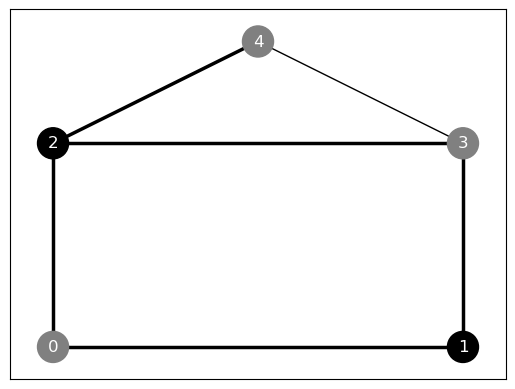

In [2]:
house = nx.house_graph()
nx.draw_networkx(
    house,
    node_size=500,
    with_labels=True,
    node_color=["grey", "black", "black", "grey", "grey"],
    font_color="white",
    width=[2.5, 2.5, 2.5, 2.5, 2.5, 1],
    pos={0: (0, 0), 1: (1, 0), 2: (0, 1), 3: (1, 1), 4: (0.5, 1.5)},
)


In [3]:
p = 1
n=4
seed = 42
with open(f"./instances/n{n}_graphs.p","rb") as f:
    graphs = pickle.load(f)

In [4]:
index = 5#np.random.randint(0,len(graphs)); print(index)

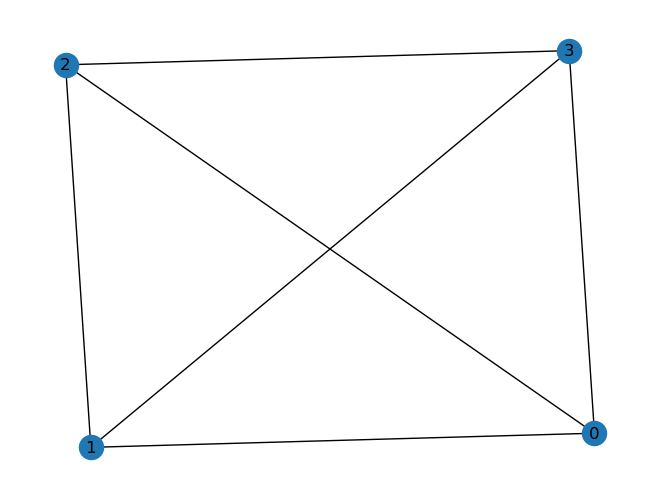

In [5]:
instance = MaxCut(graphs[index])
qaoa = QAOA(qubo=instance.qubo, p=p)
delta = tuple(1 for _ in range(2 * qaoa.p))

In [6]:
5*np.matrix(finitediff(qaoa.expectation)(delta))

matrix([[  -4.08233447, -219.26136462]])

In [7]:
gradient_descent(qaoa, delta)

done




        gradient_descent with general gradient evaluation terminated with no sucess with message
        "Gradient descent solver terminated with         no success after 1000 steps."
        This took 31.26 seconds
        
            optimal parameters: (0.6998013340743228, 1.163739155567555)
                 optimal value: -3.316200578274799
        maximal ground overlap: 0.3680462705326941
           number of fun calls: None
               number of steps: 1000
        

In [16]:
m :np.matrix = delta - gen_grad(delta, qaoa)

In [19]:
tuple(m.tolist()[0])

((1.4082283331499617+2.6751252393395895j),
 (22.926127861868522+52.32098911905819j))

In [18]:
fast_gram = qaoa.gram(delta)

In [19]:
%timeit qaoa.gram(delta)

148 ms ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
fast_grad = qaoa.grad(delta)

In [21]:
%timeit qaoa.grad(delta)

135 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
qaoa._Gij = qaoa._Gij_unitary
qaoa._grad_element = qaoa._grad_element_unitary

slow_gram = qaoa.gram(delta)
slow_grad = qaoa.grad(delta)
# %timeit qaoa.gram(delta)

qaoa._Gij  = qaoa._Gij_fast
qaoa._grad_element = qaoa._grad_element_fast

The cheating method for computing the metric is roughly 33 times faster for n=4, p=2

In [23]:
print(np.isclose(slow_gram,fast_gram))

[[ True  True]
 [ True  True]]


In [24]:
print(qaoa._Gij_fast((6,2*p),delta))
print(qaoa._Gij_unitary((6,2*p),delta))

(37.49999999999994+0j)
(37.49999999999994+0j)


In [25]:
print(np.isclose(slow_grad,fast_grad))

[[ True  True]]


In [26]:
res = tdvp_optimize_qaoa(
    qaoa,
    delta,
    1,
    int_mode="RK45",
    rhs_mode="qaoa",
    grad_tol=0.1,
    max_iter=300,
)
print(res)

donestep 55


        tdvp_optimizer with circuit gradient evaluation and RK45 as integration mode terminated with sucess with message
        "A termination event occurred."
        This took 16.08 seconds
        
            optimal parameters: (0.7478627077207184, 1.2509706947164387)
                 optimal value: -4.447065380486038
        maximal ground overlap: 0.5473436521965022
           number of fun calls: 38
               number of steps: 55
               number of gates: 7718
        


In [28]:
sci_res = scipy_optimize(qaoa, delta)
sci_res

Done Scipy_optim




        scipy_cobyla terminated with sucess with message
        "Optimization terminated successfully."
        This took 0.61 seconds
        
            optimal parameters: [2.38043609 0.7647224 ]
                 optimal value: -7.258450342343117
        maximal ground overlap: 0.7925327770111409
           number of fun calls: 64
               number of steps: None
               number of gates: 896
        